In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [2]:
# 1. Data Preprocessing

(x_train, _), (_, _) = tf.keras.datasets.cifar10.load_data()

# Use small dataset for demo
x_train = x_train[:10000]

# Convert to grayscale (input)
x_gray = tf.image.rgb_to_grayscale(x_train)

# Normalize to [-1, 1]
x_train = (x_train.astype("float32") - 127.5) / 127.5
x_gray = (x_gray.numpy().astype("float32") - 127.5) / 127.5

BUFFER_SIZE = 10000
BATCH_SIZE = 64

dataset = tf.data.Dataset.from_tensor_slices((x_gray, x_train))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


In [3]:
# 2. Build Generator (U-Net style)

def build_generator():
    inputs = layers.Input(shape=(32, 32, 1))

    # Encoder
    e1 = layers.Conv2D(64, 4, strides=2, padding="same", activation="relu")(inputs)
    e2 = layers.Conv2D(128, 4, strides=2, padding="same", activation="relu")(e1)

    # Bottleneck
    b = layers.Conv2D(256, 4, strides=2, padding="same", activation="relu")(e2)

    # Decoder
    d1 = layers.Conv2DTranspose(128, 4, strides=2, padding="same", activation="relu")(b)
    d2 = layers.Conv2DTranspose(64, 4, strides=2, padding="same", activation="relu")(d1)

    outputs = layers.Conv2DTranspose(3, 4, strides=2, padding="same", activation="tanh")(d2)

    return tf.keras.Model(inputs, outputs, name="Generator")

generator = build_generator()


In [4]:
# 3. Build Discriminator

def build_discriminator():
    inp_gray = layers.Input(shape=(32, 32, 1))
    inp_color = layers.Input(shape=(32, 32, 3))

    merged = layers.Concatenate()([inp_gray, inp_color])

    x = layers.Conv2D(64, 4, strides=2, padding="same", activation="relu")(merged)
    x = layers.Conv2D(128, 4, strides=2, padding="same", activation="relu")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    return tf.keras.Model([inp_gray, inp_color], x, name="Discriminator")

discriminator = build_discriminator()


In [5]:
# 4. Loss Functions & Optimizers

bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)


In [6]:
# 5. Training Step

@tf.function
def train_step(gray, color):
    noise = gray

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_color = generator(noise, training=True)

        real_output = discriminator([gray, color], training=True)
        fake_output = discriminator([gray, fake_color], training=True)

        # Discriminator loss
        disc_loss_real = bce(tf.ones_like(real_output), real_output)
        disc_loss_fake = bce(tf.zeros_like(fake_output), fake_output)
        disc_loss = disc_loss_real + disc_loss_fake
        
        # Generator loss (fool disc + L1 reconstruction loss)
        gen_loss_adv = bce(tf.ones_like(fake_output), fake_output)
        l1_loss = tf.reduce_mean(tf.abs(color - fake_color))
        gen_loss = gen_loss_adv + 100 * l1_loss # Giving more importance to the L1 loss


    # Backprop
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)

    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))

    return gen_loss, disc_loss


In [7]:
# 6. Training Loop

EPOCHS = 25

for epoch in range(EPOCHS):
    for gray, color in dataset:
        g_loss, d_loss = train_step(gray, color)
    print(f"Epoch {epoch+1}, Generator Loss: {g_loss:.4f}, Discriminator Loss: {d_loss:.4f}")


Epoch 1, Generator Loss: 23.3370, Discriminator Loss: 0.1723
Epoch 2, Generator Loss: 24.6357, Discriminator Loss: 0.0374
Epoch 3, Generator Loss: 21.7817, Discriminator Loss: 0.0655
Epoch 4, Generator Loss: 22.8838, Discriminator Loss: 0.0151
Epoch 5, Generator Loss: 24.5143, Discriminator Loss: 0.0168
Epoch 6, Generator Loss: 21.2747, Discriminator Loss: 0.0687
Epoch 7, Generator Loss: 19.7395, Discriminator Loss: 0.0220
Epoch 8, Generator Loss: 25.2045, Discriminator Loss: 0.0045
Epoch 9, Generator Loss: 24.6860, Discriminator Loss: 0.0159
Epoch 10, Generator Loss: 18.7298, Discriminator Loss: 0.0662
Epoch 11, Generator Loss: 22.9984, Discriminator Loss: 0.0218
Epoch 12, Generator Loss: 21.0427, Discriminator Loss: 0.0515
Epoch 13, Generator Loss: 21.0298, Discriminator Loss: 0.0117
Epoch 14, Generator Loss: 21.5499, Discriminator Loss: 0.0132
Epoch 15, Generator Loss: 18.8815, Discriminator Loss: 0.0269
Epoch 16, Generator Loss: 21.1728, Discriminator Loss: 0.0037
Epoch 17, Generat

In [ ]:
# 7. Test Generator

def generate_images(model, test_input, target):
    prediction = model(test_input, training=False)
    plt.figure(figsize=(12, 4))

    display_list = [test_input[0], prediction[0], target[0]]
    title = ['Input (Gray)', 'Predicted (Color)', 'Real (Color)']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        img = (display_list[i] + 1) / 2
        plt.imshow(tf.squeeze(img))
        plt.axis('off')
    plt.show()


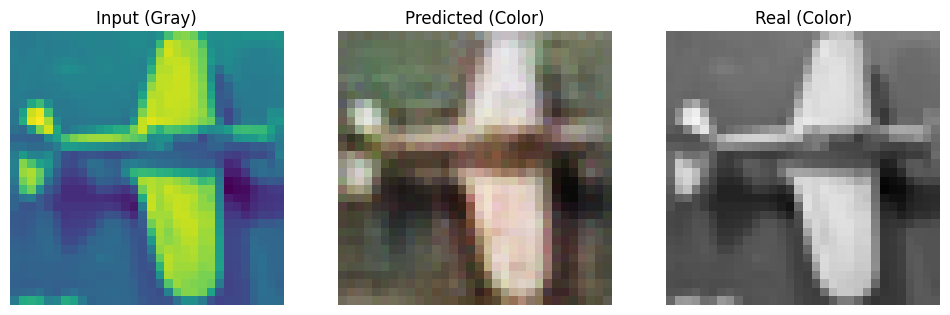

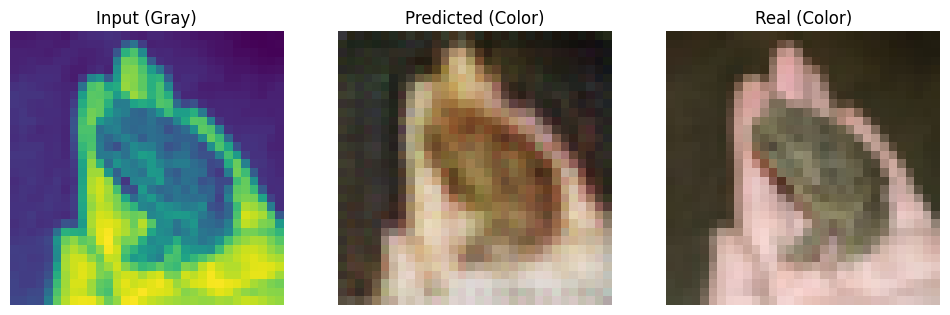

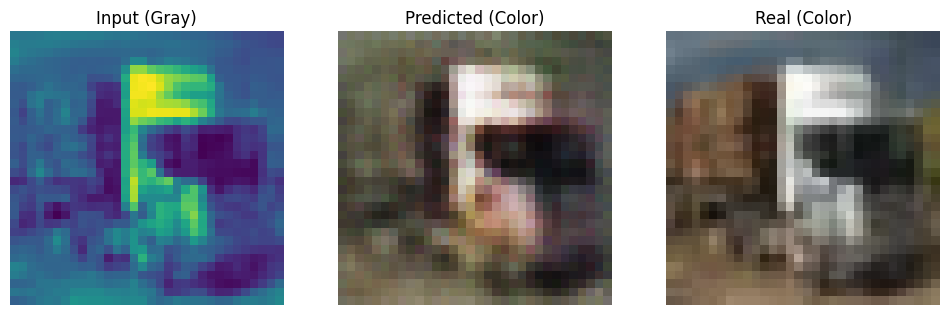

In [17]:
# Pick one test sample
for gray, color in dataset.take(3):
    generate_images(generator, gray, color)


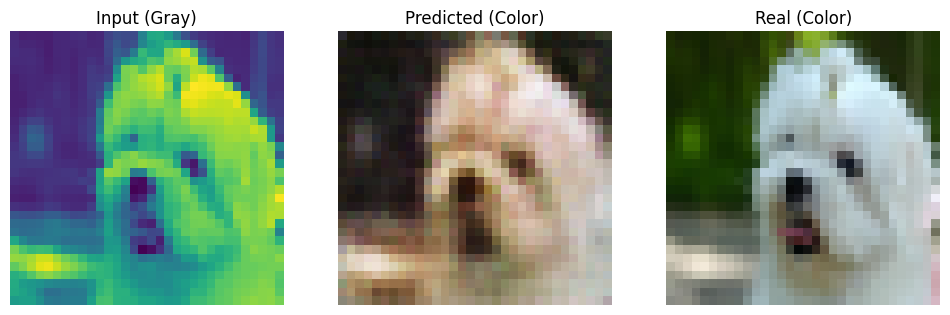

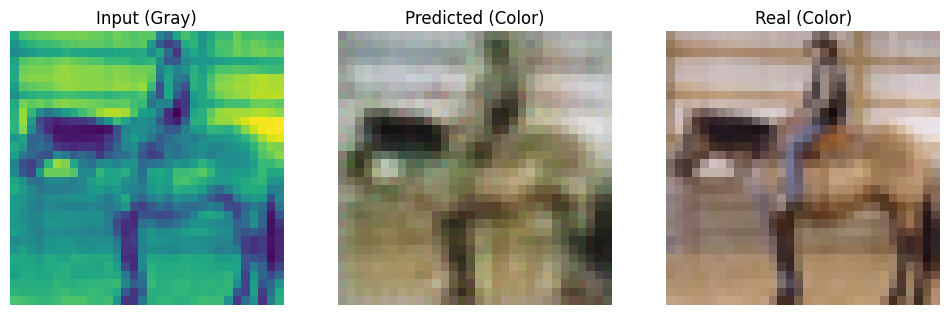

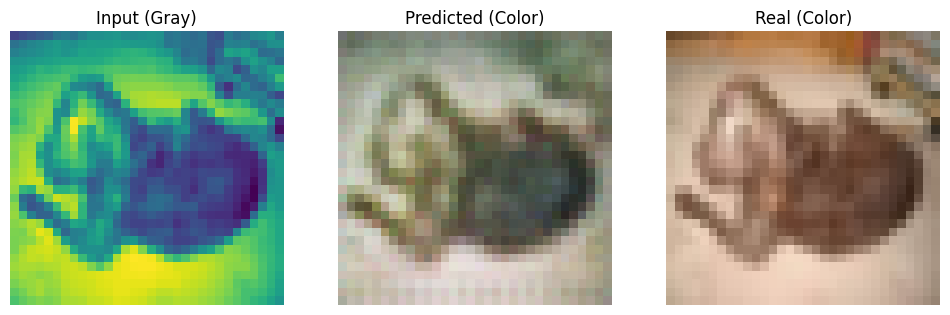

In [27]:
# Pick one test sample
for gray, color in dataset.take(3):
    generate_images(generator, gray, color)
